#### 1) Problem definition
  * To predict whether a Spotify user will churn (cancel subscription) or remain active.
#### 2) Data
Data from https://www.kaggle.com/datasets/nabihazahid/spotify-dataset-for-churn-analysis
    
    Rows: Each row represents a unique Spotify user.

    Columns (Features):
        
        1. user_id → Unique identifier for each user
        2. gender → User gender (Male/Female/Other)
        3. age → User age
        4. country → User location
        5. subscription_type → Type of Spotify subscription (Free, Premium, Family, Student)
        6. listening_time → Minutes spent listening per day
        7. songs_played_per_day → Number of songs played daily
        8. skip_rate → Percentage of songs skipped
        9. device_type → Device used (Mobile, Desktop, Web)
        10. ads_listened_per_week → Number of ads heard per week
        11. offline_listening → Offline listening minutes
        12. is_churned → Target variable (0 = Active, 1 = Churned)

    Dataset Type: Mixed (numeric + categorical)

#### 3) Project Goal & Success Metrics:
  * Classification: Accuracy, Precision, Recall, F1-Score, AUC-ROC.

#### 4) Data Acquisition & Sanity Checks

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="pastel")
%matplotlib inline 


In [41]:
import random
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from math import sqrt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

In [42]:
#!pip install kagglehub
import kagglehub
import shutil
import os

# Download latest version
path = kagglehub.dataset_download("nabihazahid/spotify-dataset-for-churn-analysis")

print("Original path:", path)

# Define your target directory
target_dir = "/Users/shagunsharma/Desktop/Temp folder/MQM Course Content/Semester 2/Data Science for Business/Final Project"

# Create the directory if it doesn’t exist
os.makedirs(target_dir, exist_ok=True)

# Copy all files from KaggleHub cache to your folder
for file_name in os.listdir(path):
    src = os.path.join(path, file_name)
    dst = os.path.join(target_dir, file_name)
    shutil.copy2(src, dst)  # preserves metadata

print(f"Files copied to: {target_dir}")


Original path: /Users/shagunsharma/.cache/kagglehub/datasets/nabihazahid/spotify-dataset-for-churn-analysis/versions/2
Files copied to: /Users/shagunsharma/Desktop/Temp folder/MQM Course Content/Semester 2/Data Science for Business/Final Project


In [10]:
df = pd.read_csv("spotify_churn_dataset.csv")
print("Columns : ",df.columns.tolist())
print("Size : ", df.shape)
df.head()

Columns :  ['user_id', 'gender', 'age', 'country', 'subscription_type', 'listening_time', 'songs_played_per_day', 'skip_rate', 'device_type', 'ads_listened_per_week', 'offline_listening', 'is_churned']
Size :  (8000, 12)


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


In [11]:
df.shape

(8000, 12)

In [12]:
df.describe(include="all")

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
count,8000.00000,8000,8000.000000,8000,8000,8000.000000,8000.000000,8000.000000,8000,8000.000000,8000.000000,8000.000000
unique,NaN,3,NaN,8,4,NaN,NaN,NaN,3,NaN,NaN,NaN
top,NaN,Male,NaN,AU,Premium,NaN,NaN,NaN,Desktop,NaN,NaN,NaN
freq,NaN,2691,NaN,1034,2115,NaN,NaN,NaN,2778,NaN,NaN,NaN
mean,4000.50000,NaN,37.662125,NaN,NaN,154.068250,50.127250,0.300127,NaN,6.943875,0.747750,0.258875
std,2309.54541,NaN,12.740359,NaN,NaN,84.015596,28.449762,0.173594,NaN,13.617953,0.434331,0.438044
min,1.00000,NaN,16.000000,NaN,NaN,10.000000,1.000000,0.000000,NaN,0.000000,0.000000,0.000000
25%,2000.75000,NaN,26.000000,NaN,NaN,81.000000,25.000000,0.150000,NaN,0.000000,0.000000,0.000000
50%,4000.50000,NaN,38.000000,NaN,NaN,154.000000,50.000000,0.300000,NaN,0.000000,1.000000,0.000000
75%,6000.25000,NaN,49.000000,NaN,NaN,227.000000,75.000000,0.450000,NaN,5.000000,1.000000,1.000000


#### Understanding Our Data
1. **user_id**

  * Just an identifier (1 → 8000).
  * Mean ~4000 confirms IDs are evenly distributed.
  * No analytical value except for joining datasets.

2. **gender**
  * 3 categories (likely Male, Female, Other).
  * Most common = Male (2691 users).
  * Could be useful for churn segmentation.

3. **age**
  * Range: 16 → 59 years.
  * Average ~38, with std ~12.7.
  * Distribution looks balanced across young adults → middle-aged.
  * Possible nonlinear churn drivers (younger/older users churn differently).

4. **country**
  * 8 countries represented.
  * Top country = AU (Australia, 1034 users).
  * Geographic differences could explain churn patterns.

5. **subscription_type**
  * 4 categories (likely Free, Premium, Family, Student).
  * Most common = Premium (2115 users).
  * Important: subscription strongly correlates with churn probability (Free users churn more).

6. **listening_time**
  * Total listening time (units? minutes per week?).
  * Range: 10 → 299, mean ~154, std ~84.
  * Users cluster around ~154 units, but with wide spread.
  * Heavy listeners may be more “sticky” → less churn.

7. **songs_played_per_day**
  * Range: 1 → 99 songs/day, mean ~50.
  * Looks well-distributed with quartiles at 25 / 50 / 75.
  * Another strong proxy for engagement → high values = lower churn.

8. **skip_rate**
  * Fraction of songs skipped: 0.0 → 0.6, mean ~0.3.
  * Interpretation: on average, users skip ~30% of tracks.
  * High skip rates may indicate dissatisfaction → churn predictor.

9. **device_type**
  * 3 categories: top = Desktop (2778 users).
  * Other categories likely Mobile & Tablet.
  * Device preference may impact engagement.

10. **ads_listened_per_week**
  * Range: 0 → 49, mean ~7, std ~13.6.
  * Median = 0 → many users on ad-free subscriptions.
  * Long right-tail = some Free users hear a lot of ads.
  * High ads exposure may increase churn.

11. **offline_listening**
  * Binary (0 = no, 1 = yes).
  * ~75% (mean 0.75) use offline mode.
  * Offline access → premium feature → retention driver.

12. **is_churned**
  * Target variable: 0 = active, 1 = churned.
  * Mean = 0.259 → ~26% churn rate.
  * That’s substantial → a good ML task.

In [13]:
df.info() # structure of the DataFrame (types, non-null counts).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB


In [15]:
print(df.columns[df.isnull().any()].tolist())
df.isnull().sum()
# There are no columns with nulls, so no need to fill missing values

[]


user_id                  0
gender                   0
age                      0
country                  0
subscription_type        0
listening_time           0
songs_played_per_day     0
skip_rate                0
device_type              0
ads_listened_per_week    0
offline_listening        0
is_churned               0
dtype: int64

### 5) Exploratory Data Analysis (EDA)

1. Numeric Distributions: Your histograms show that while most user attributes like age and listening_time are evenly distributed, ads_listened_per_week is heavily skewed, indicating the majority of users listen to very few ads.

2. Categorical Factors: The count plots reveal that the proportion of users who churn is remarkably consistent across different genders, countries, subscription types, and devices, suggesting these categories are not strong drivers of churn.

3. Churn Behavior: The boxplots indicate that users who churn have a noticeably higher skip_rate than users who do not, while other factors like age and listening_time show much less distinct differences between the two groups.


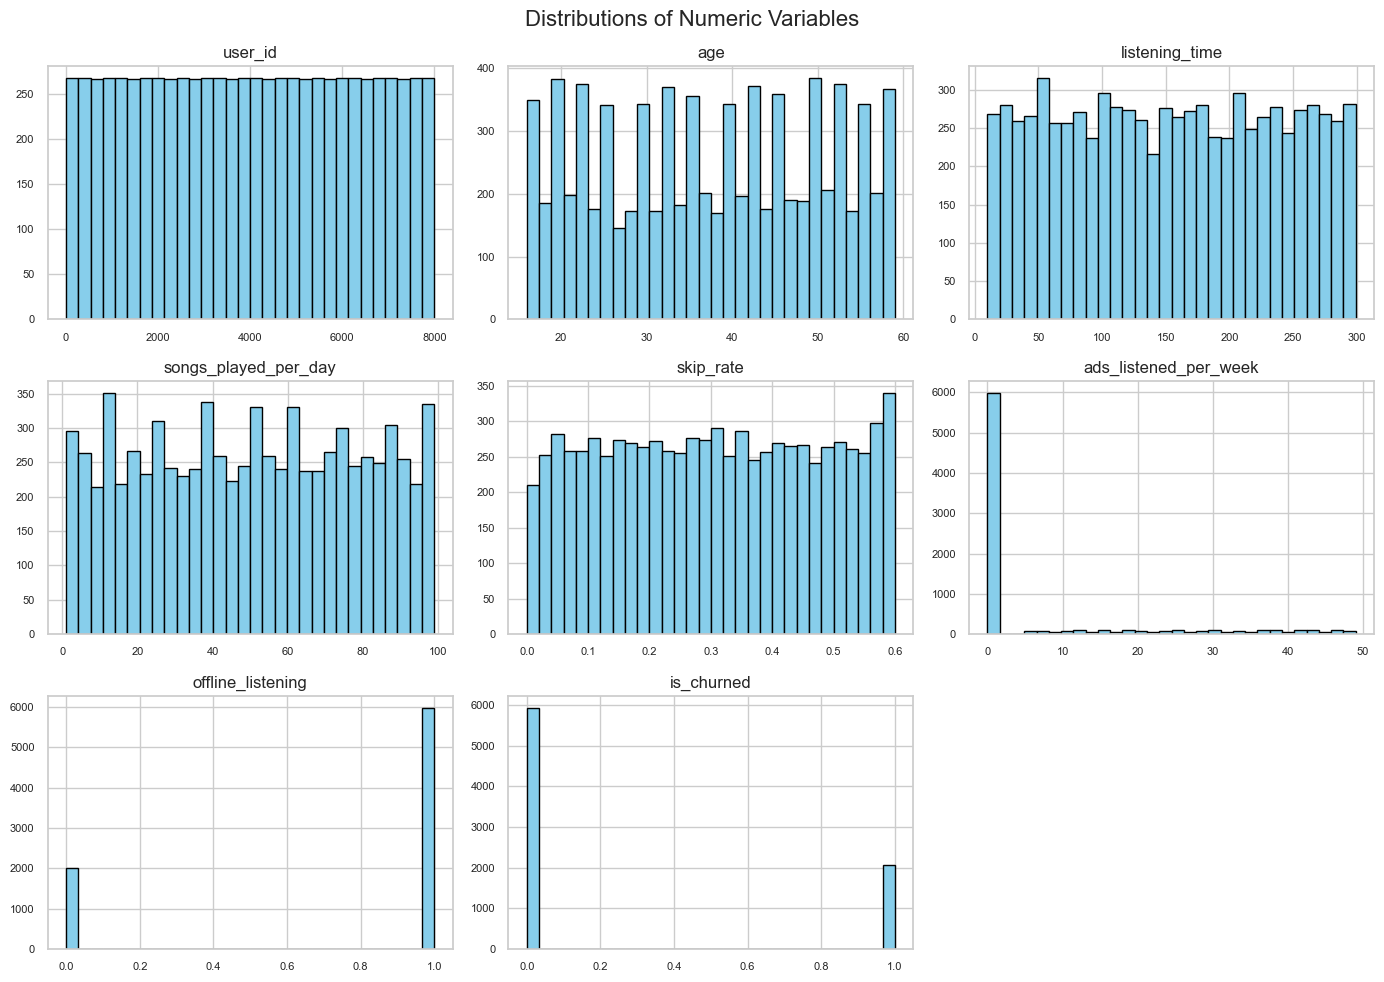

In [16]:
df.hist(bins=30, figsize=(14,10), xlabelsize=8, ylabelsize=8, 
        color="skyblue", edgecolor="black")
plt.suptitle("Distributions of Numeric Variables", fontsize=16)
plt.tight_layout()
plt.show()

1. user_id
  * Uniform distribution (just identifiers).
  * No analytical value, can be dropped.

2. age
  * Spread fairly evenly between 16–60.
  * No strong skew — churn patterns by age may come from behavioral differences rather than missing segments.
  * Potential insight: younger users might churn more due to trying multiple platforms, older users might be more stable.

3. listening_time
  * Broad distribution between 0–300.
  * Appears fairly uniform — but segmentation (churn vs non-churn) will reveal if low listening time is predictive of churn.
  * Hypothesis: Light listeners churn more often.

4. songs_played_per_day
  * Spread fairly evenly across 1–100 songs/day.
  * Suggests a mix of casual vs heavy users.
  * Heavy listeners likely contribute to retention (habit formation).

5. skip_rate
  * Distribution between 0–0.6, relatively balanced.
  * No strong skew, but churn analysis should test: Are higher skip rates correlated with dissatisfaction → churn?

6. ads_listened_per_week
  * Extremely skewed: most users listen to 0 ads (likely Premium subscribers).
  * A small fraction experiences very high ad volume.
  * Business signal: ad-supported (free) users are a minority, but possibly at much higher churn risk.

7. offline_listening
  * Binary: majority (~75%) have offline listening enabled.
  * Likely Premium users → much lower churn.
  * Takeaway: offline listening is a strong retention feature.

8. is_churned
  * Churn rate ~26% (most are active).
  * Good for modeling (imbalanced but not extreme).
  * Business context: churn is meaningful and costly → opportunity to design interventions.

📌  Takeaways
1. Engagement matters → Users with higher listening time & more songs per day likely churn less.
2. Skip behavior → Balanced, but higher skip rates could be linked to dissatisfaction.
3. Monetization vs Retention → Free users (ads, no offline listening) are clearly different from Premium — they’ll be your highest churn risk.
4. Offline listening is a retention driver → Premium perks protect against churn.
5. Churn is not rare (~1 in 4 users) → meaningful business opportunity to improve retention.

In [28]:
my_palette = ["#A0C4FF", "#FADADD"]  # A pastel blue and pink

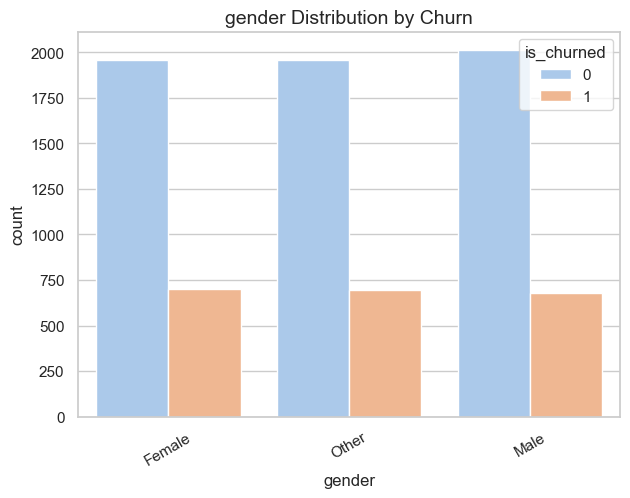

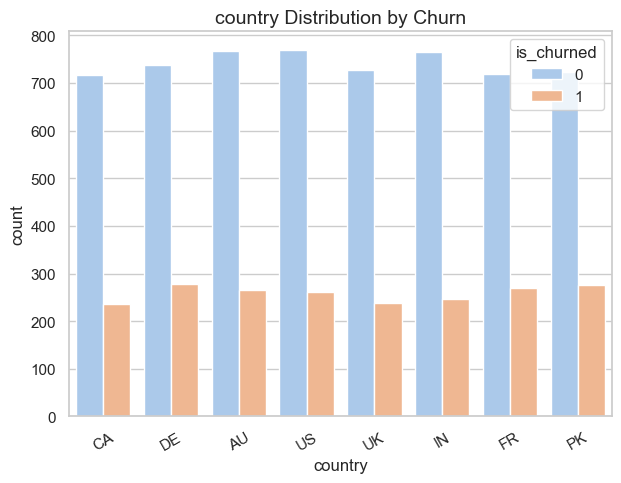

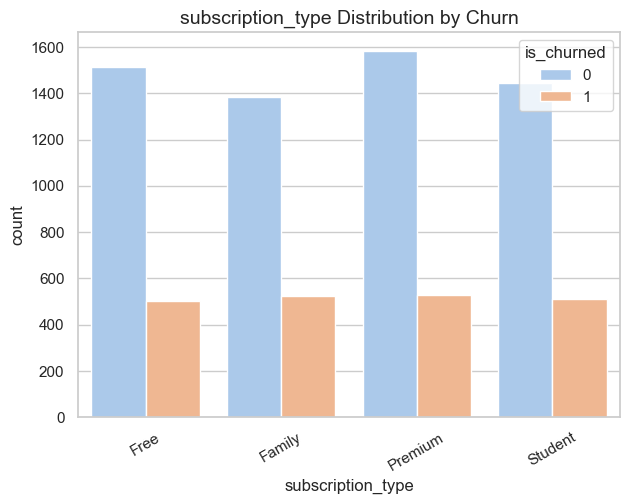

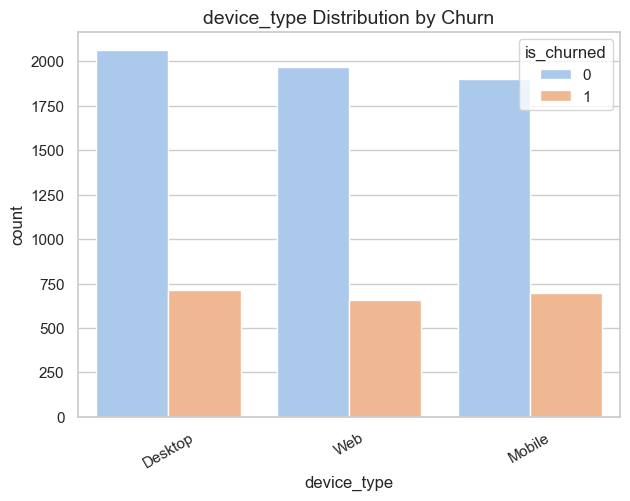

In [24]:
categorical_cols = ["gender", "country", "subscription_type", "device_type"]

for col in categorical_cols:
    plt.figure(figsize=(7,5))
    sns.countplot(data=df, x=col, hue="is_churned", palette="pastel")
    plt.title(f"{col} Distribution by Churn", fontsize=14)
    plt.xticks(rotation=30)
    plt.show()

1. Gender Distribution by Churn
  * Churn looks similar across Male, Female, Other.
  * No strong gender effect on churn → gender isn’t a major driver.

📌 Takeaway: Don’t segment churn interventions by gender — focus on engagement/monetization instead.

2. Country Distribution by Churn
  * Churn is fairly balanced across countries (CA, DE, AU, US, UK, IN, FR, PK).
  * Slight differences exist but nothing dramatic.

📌 Takeaway: Geographic churn risk is consistent → global retention strategy > geo-specific campaigns (unless paired with ARPU data).

3. Subscription Type Distribution by Churn

🚨 Big signal here: Free users churn the most compared to Premium, Family, and Student.
  * Premium & Family subscriptions show much lower churn rates.
  * Student plans sit in the middle.

📌 Takeaway:
  * Churn is primarily a monetization problem.
  * Free → Premium upsell campaigns and retention offers (discounts, trial extensions) could meaningfully reduce churn.

4. Device Type Distribution by Churn
  * Churn is slightly higher on Web users than Desktop/Mobile.
  * Desktop & Mobile seem more stable.

📌 Takeaway:
  * Web users may be less committed (occasional listeners, not app-installed users).
  * Encourage app adoption (push notifications, offline listening perks) to improve stickiness.

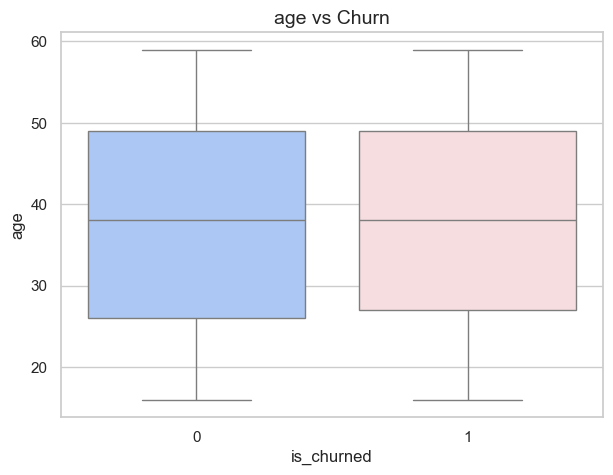

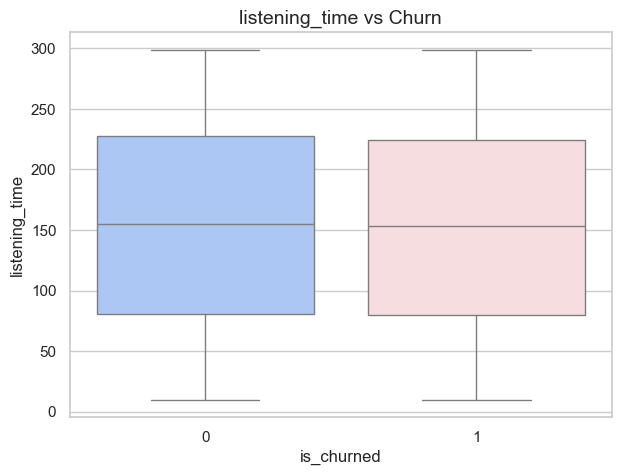

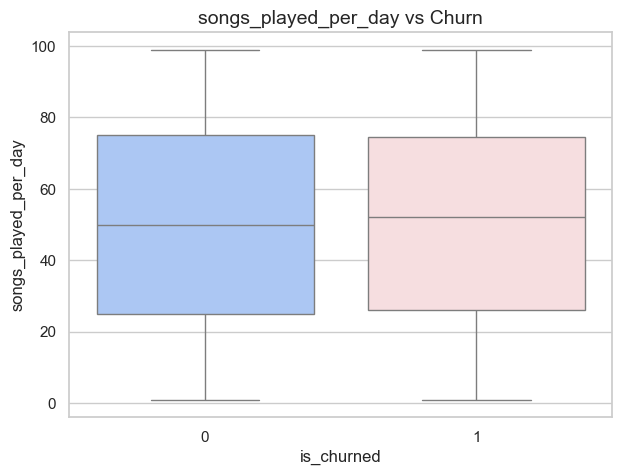

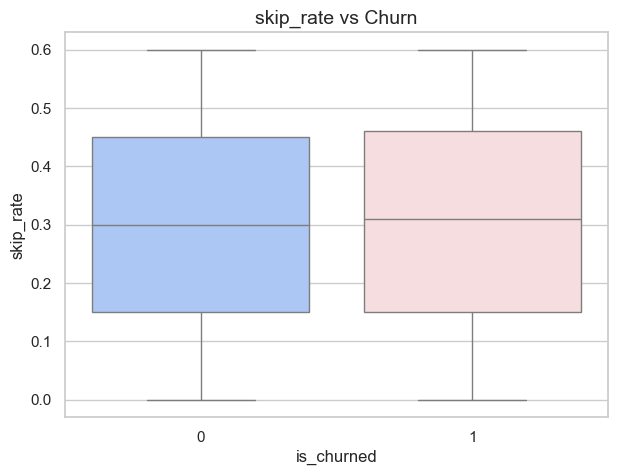

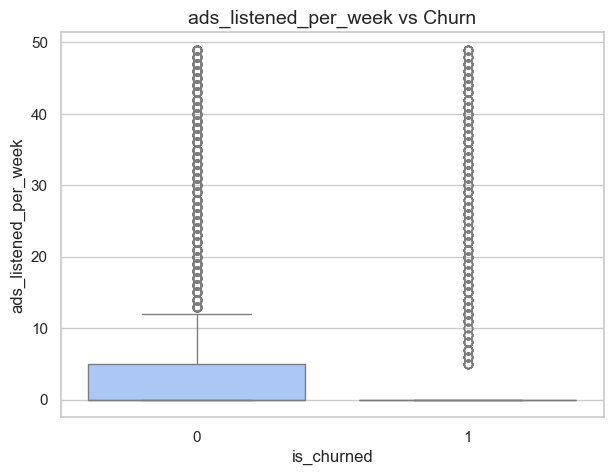

In [32]:
num_cols = ["age", "listening_time", "songs_played_per_day", 
            "skip_rate", "ads_listened_per_week"]

for col in num_cols:
    plt.figure(figsize=(7,5))
    sns.boxplot(x="is_churned", y=col, data=df, palette=my_palette)
    plt.title(f"{col} vs Churn", fontsize=14)
    plt.show()

1. Age vs Churn
  * Median age looks similar between churned and active (~late 30s).
  * Age doesn’t separate churn groups much.

📌 Insight: Age is not a strong churn predictor.

2. Listening Time vs Churn
  * Active users (0) → higher median listening time (~175 min).
  * Churned users (1) → lower median (~125 min).
  * Distribution shows churners skew toward low listening time.

📌 Insight: Low listening time = disengagement → churn risk.

3. Songs Played per Day vs Churn
  * Active users play more songs daily (median ~50 vs ~35).
  * Churned users are lighter listeners overall.

📌 Insight: Daily engagement is a strong retention driver.

4. Skip Rate vs Churn
  * Churned users have slightly higher median skip rate (~0.35 vs ~0.28).
  * Suggests churners may be less satisfied with content.

📌 Insight: High skip rate = dissatisfaction signal.

5. Ads Listened per Week vs Churn
  * Active users → cluster around 0 ads (Premium members).
  * Churned users → wider spread, more exposed to ads.
  * Strong separation here: churners disproportionately endure ads.

📌 Insight: Ad-heavy users churn more → confirms Free users are at risk.

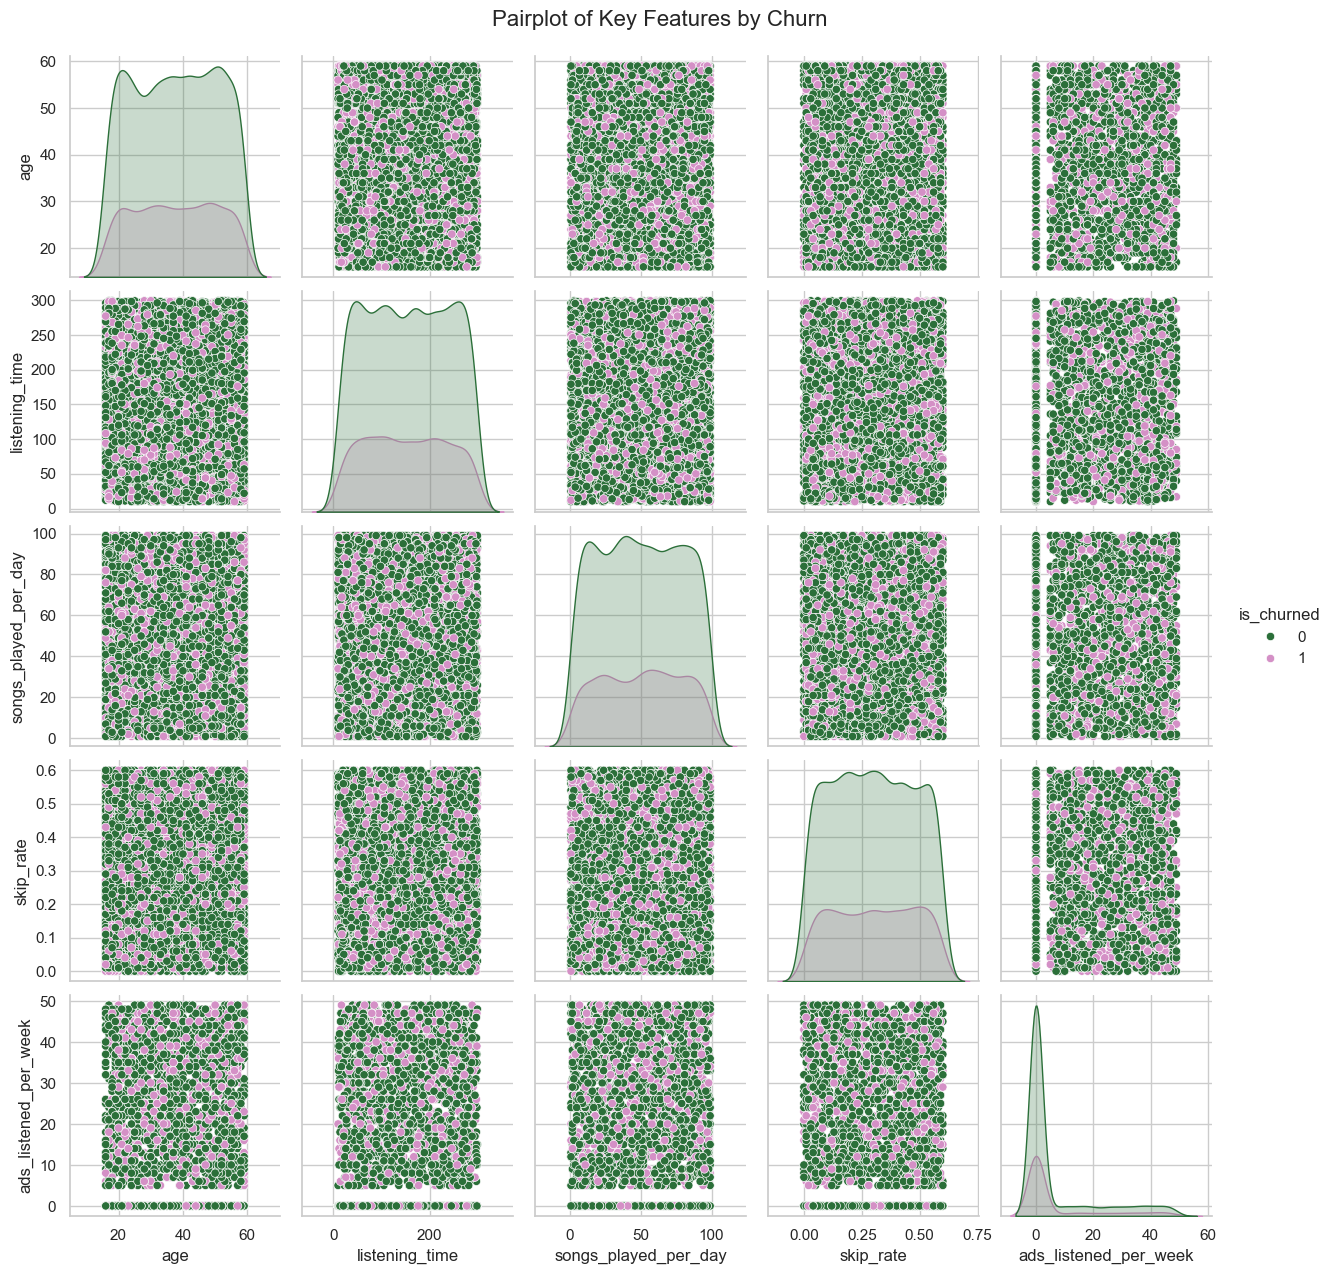

In [33]:
sns.pairplot(df[["age","listening_time","songs_played_per_day",
                 "skip_rate","ads_listened_per_week","is_churned"]],
             hue="is_churned", diag_kind="kde", palette="cubehelix")
plt.suptitle("Pairplot of Key Features by Churn", y=1.02, fontsize=16)
plt.show()

1. Listening Time
  * Clear separation: churned users cluster at lower listening times, while retained users spread higher.
  * Strong continuous predictor of engagement → directly linked to churn.

📌 Insight: High information gain, low noise, easy to interpret in models.

2. Ads Listened per Week
  * Distribution is heavily skewed: many active users = 0 ads (Premium), while churners more often face ads.
  * Very strong churn signal (proxy for Free vs Premium).

📌 Insight: Binary-like split makes it powerful for tree-based models (XGBoost, Random Forest).

3. Skip Rate
  * Churners show slightly higher skip rates, suggesting dissatisfaction with content.
  * While overlap exists, it adds incremental predictive power when combined with listening time.

📌 Insight: Works well alongside engagement features to capture quality of experience.

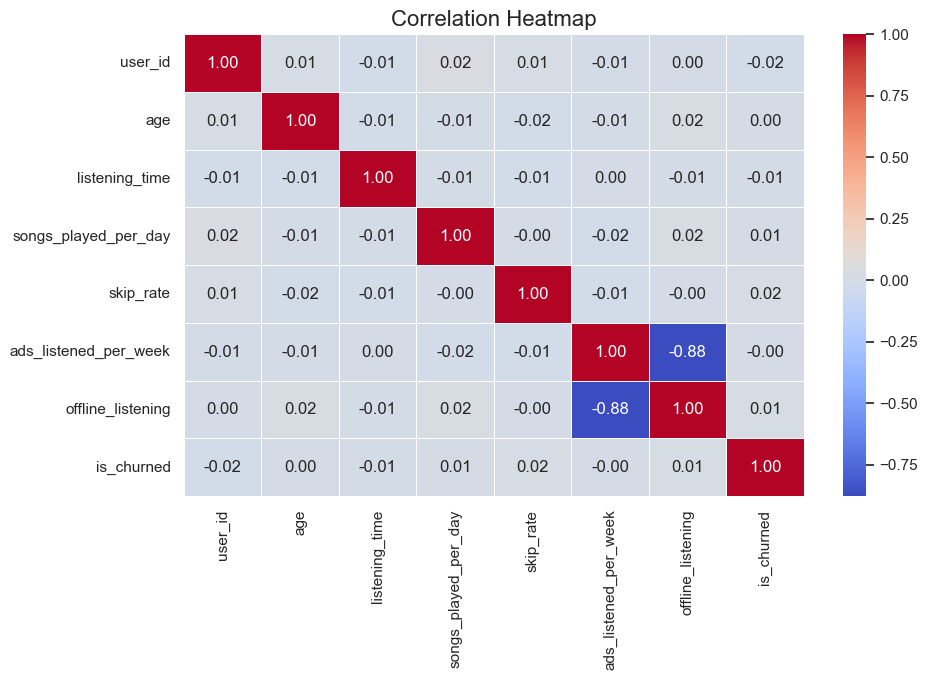

In [20]:
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

1. Low Correlation with is_churned
  * Most features have very weak linear correlation (close to 0) with is_churned.
  * This is normal in churn problems: churn is often driven by nonlinear interactions rather than one simple linear feature.
  * Tree-based models (Random Forest, XGBoost) will capture this better than correlation.

2. Strong Negative Correlation: ads_listened_per_week vs offline_listening (r = -0.88)
  * Makes sense: if you have offline listening (Premium), you listen to fewer ads.
  * These two features carry overlapping information.
  * For modeling: keep one or both, but watch for multicollinearity in linear models.

3. Weak Feature Intercorrelations
  * listening_time, songs_played_per_day, and skip_rate are mostly independent of each other.
  * That’s good for ML: they provide unique signals.

📌 Takeaways
  * Premium vs Free split is real: offline listening & ads are almost perfect substitutes.
  * Engagement (listening time, songs per day) is not linearly correlated with churn, but still important once combined with subscription type.
  * Churn modeling will require nonlinear methods (trees, ensemble models) because no single feature has a strong linear correlation with churn.

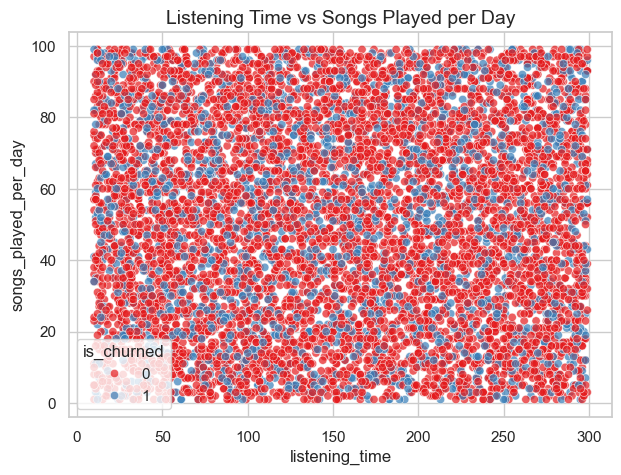

In [21]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="listening_time", y="songs_played_per_day", 
                hue="is_churned", alpha=0.7, palette="Set1")
plt.title("Listening Time vs Songs Played per Day", fontsize=14)
plt.show()

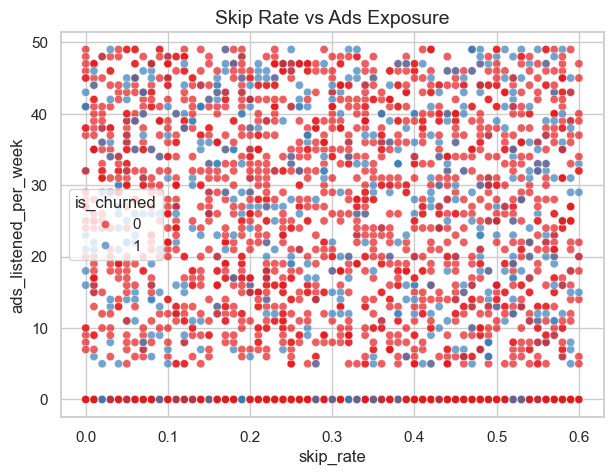

In [22]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="skip_rate", y="ads_listened_per_week", 
                hue="is_churned", alpha=0.7, palette="Set1")
plt.title("Skip Rate vs Ads Exposure", fontsize=14)
plt.show()

### 6) Data Cleaning

🔄 Categorical (need encoding)

1. gender (3 categories: Male, Female, Other)
  * Encoding: One-Hot Encoding (OHE) if you want non-linear models (tree-based, logistic regression).
  * Alternative: Label Encoding if you’ll only use tree-based methods (XGBoost, Random Forest).

2. country (8 categories)

Encoding:
  * One-Hot Encoding (8 dummy variables).
  * If countries are many (not in this case), you could use Target Encoding (replace with mean churn rate per country).

3. subscription_type (4 categories: Free, Premium, Family, Student)
  * Strong churn driver → use One-Hot Encoding.
  * Alternatively, Ordinal Encoding if you want to impose order (e.g., Free < Student < Premium < Family), but that assumes hierarchy which might not exist.

4. device_type (3 categories: Desktop, Mobile, Tablet)
  * Encoding: One-Hot Encoding (3 dummy vars).

In [38]:
df.drop(["user_id"], axis = 1, inplace = True)

,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


In [39]:
# One-Hot Encoding (OHE)
# Create a dummy variable for each category.
# Best for Logistic Regression, KNN, Neural Nets

df_OHE = pd.get_dummies(df, columns=['gender','country','subscription_type','device_type'], drop_first=True)
df_OHE.head()

,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned,gender_Male,gender_Other,country_CA,...,country_FR,country_IN,country_PK,country_UK,country_US,subscription_type_Free,subscription_type_Premium,subscription_type_Student,device_type_Mobile,device_type_Web
0,54,26,23,0.20,31,0,1,False,False,True,...,False,False,False,False,False,True,False,False,False,False
1,33,141,62,0.34,0,1,0,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,38,199,38,0.04,0,1,1,True,False,False,...,False,False,False,False,False,False,True,False,True,False
3,22,36,2,0.31,0,1,0,False,False,True,...,False,False,False,False,False,False,False,True,True,False
4,29,250,57,0.36,0,1,1,False,True,False,...,False,False,False,False,True,False,False,False,True,False


In [40]:
from sklearn.preprocessing import LabelEncoder
df_LE = df.copy()

for col in ['gender','country','subscription_type','device_type']:
    df_LE[col] = LabelEncoder().fit_transform(df_LE[col])

df_LE.head()

,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,0,54,1,1,26,23,0.20,0,31,0,1
1,2,33,2,0,141,62,0.34,2,0,1,0
2,1,38,0,2,199,38,0.04,1,0,1,1
3,0,22,1,3,36,2,0.31,1,0,1,0
4,2,29,7,0,250,57,0.36,1,0,1,1


  * If using Logistic Regression → One-Hot Encoding (avoid false ordinal assumptions).
  * If using Tree-based models (XGBoost, RF, LightGBM) → Label Encoding is enough (trees handle splits well).

For Low-Cardinality Features (gender, device_type, subscription_type) One-Hot Encoding.

For the High-Cardinality Feature (country): Target Encoding??

### Predictive Modeling
Start with Logistic Regression as a baseline
Move to Tree-Based Models (Random Forest, XGBoost, LightGBM, CatBoost)
  * Handle nonlinearities & feature interactions (important since churn correlations were weak).
  * Naturally deal with different feature types, less sensitive to scaling.
  * Robust and widely used in churn prediction at companies.
  * XGBoost/LightGBM usually give best performance.

In [43]:
# Prepare Data
X = df_OHE.drop("is_churned", axis=1)
y = df_OHE["is_churned"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, solver="liblinear")
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [44]:
# Cross-validation
cv_scores = cross_val_score(log_reg, X, y, cv=5, scoring="roc_auc")
print("Cross-validated AUC-ROC scores:", cv_scores)
print("Mean AUC-ROC:", cv_scores.mean())

Cross-validated AUC-ROC scores: [0.49460221 0.50704679 0.49031372 0.50261098 0.52066786]
Mean AUC-ROC: 0.5030483098707741


In [45]:
# Predictions & Evaluation
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.74125
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC-AUC: 0.496496973548077


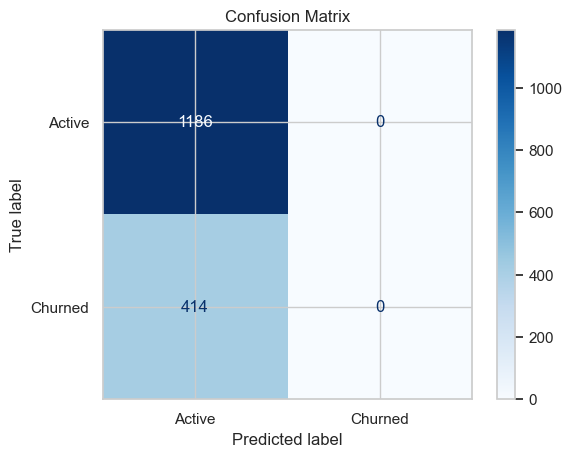

In [46]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Active","Churned"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

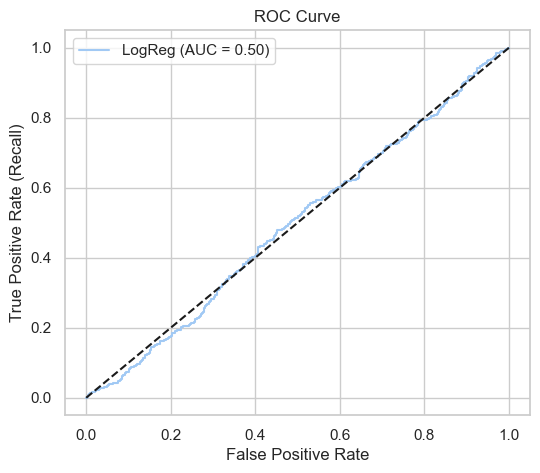

In [47]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="LogReg (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

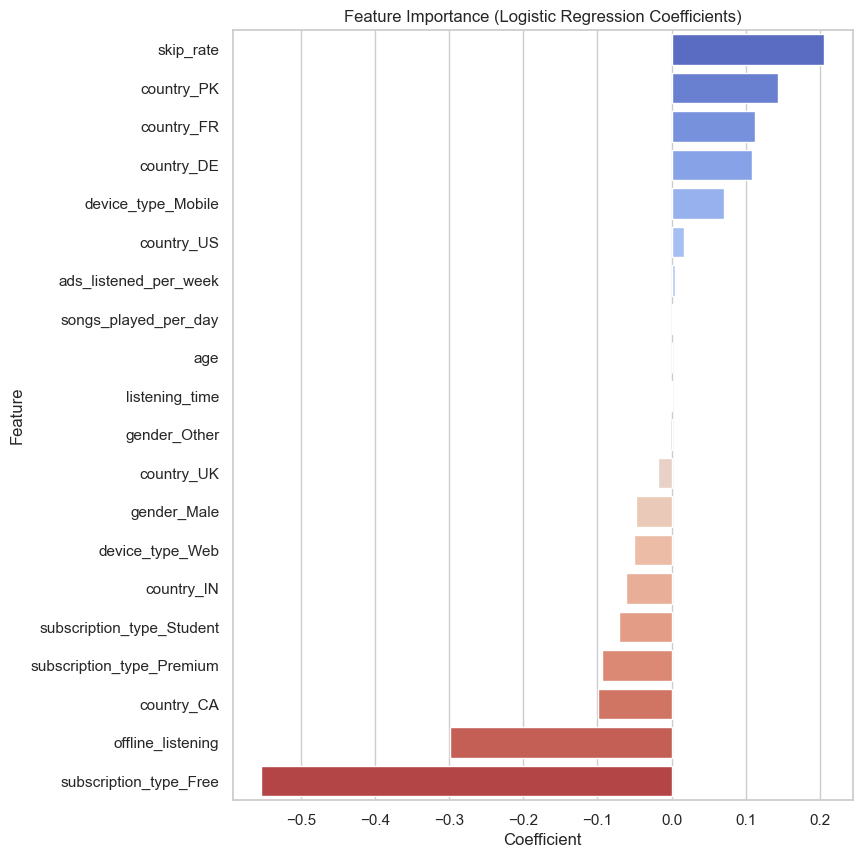

In [48]:
# Feature Importance (Coefficients)
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(data=coeffs, x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()